In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.sandbox.stats.runs import runstest_1samp
from sklearn.preprocessing import StandardScaler

In [2]:
df_nasd = pd.read_csv('Dataset updated/NASDAQ.csv')
df_infy_nyse = pd.read_csv('Dataset updated/INFOSYS.ADR-2010-2022.csv')
df_infy_nse = pd.read_csv('Dataset updated/INFOSYS.NSE-2010-2022.csv')
df_infy_nse = df_infy_nse.dropna().reset_index(drop=True)

In [3]:
class ShapingDF:
    def __init__(self, nse, nyse, idx):
        self.nse = nse
        self.nyse = nyse.add_prefix('nyse_pre')
        self.idx = idx.add_prefix('idx_pre')
        self.df_temp = pd.merge(self.nse, self.nyse, left_on='Date', right_on='nyse_preDate')
        self.df_temp = pd.merge(self.df_temp, self.idx, left_on='Date', right_on='idx_preDate')
    
    def DF_concat(self):
        nse_Open = pd.Series(self.df_temp['Open'].iloc[1:].reset_index(drop=True), name="nse_Open") #
        nse_Close = pd.Series(self.df_temp['Close'].iloc[1:].reset_index(drop=True), name="nse_Close") 
        nse_delta = pd.Series((nse_Close - nse_Open) * 100 / nse_Open, name="nse_delta %") #
        nse_preClose = pd.Series(self.df_temp['Close'].iloc[:-1], name="nse_preClose") #
        
        
        df_temp_drop0 = self.df_temp.drop(index = 0).reset_index(drop=True)
        nse_Close_Open = df_temp_drop0['Close'] / df_temp_drop0['Open'] 
        for i in nse_Close_Open.index:
            if nse_Close_Open[i] > 1:
                nse_Close_Open[i] = 1
            else:
                nse_Close_Open[i] = 0
        nse_Close_Open = pd.Series(pd.Categorical(nse_Close_Open), name="nse_Close-Open_sign") # 
        
        df_temp_dropLast = self.df_temp[:-1]
        nyse_delta = pd.Series((df_temp_dropLast['nyse_preClose'] - df_temp_dropLast['nyse_preOpen']) * 100 / df_temp_dropLast['nyse_preOpen'],
                              name="nyse_delta %") #
        df_preNYSE_IDX = df_temp_dropLast.drop(columns=['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume', 
                                                        'nyse_preDate', 'nyse_preAdj Close', 
                                                        'idx_preDate', 'idx_preAdj Close', 'idx_preVolume'])
       
        
        return pd.concat([nse_Close_Open, df_preNYSE_IDX, nyse_delta, nse_delta, nse_Open], axis=1)
    
    

In [4]:
test = ShapingDF(df_infy_nse, df_infy_nyse, df_nasd)

# EDA

In [5]:
DF = test.DF_concat().drop(columns='Date')
DF

,nse_Close-Open_sign,nyse_preOpen,nyse_preHigh,nyse_preLow,nyse_preClose,nyse_preVolume,idx_preOpen,idx_preHigh,idx_preLow,idx_preClose,nyse_delta %,nse_delta %,nse_Open
0,1.0,7.002500,7.112500,7.001250,7.095000,11443200,2294.409912,2311.149902,2294.409912,2308.419922,1.320957,0.051530,327.500000
1,0.0,7.087500,7.125000,7.048750,7.122500,8181600,2307.270020,2313.729980,2295.620117,2308.709961,0.493827,-3.723440,335.375000
2,0.0,7.072500,7.072500,6.970000,7.013750,11821600,2307.709961,2314.070068,2295.679932,2301.090088,-0.830682,-2.379573,323.325012
3,0.0,6.885000,6.896250,6.777500,6.800000,20374400,2298.090088,2301.300049,2285.219971,2300.050049,-1.234568,-2.175468,314.875000
4,1.0,6.721250,6.856250,6.693750,6.817500,11551200,2292.239990,2317.600098,2290.610107,2317.169922,1.432025,0.587847,309.387512
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,1.0,19.090000,19.290001,18.920000,19.200001,9282800,10869.169922,11119.120117,10779.950195,11114.150391,0.576223,1.516177,1546.650024
3080,1.0,19.510000,19.790001,19.360001,19.750000,6249900,11124.750000,11352.429688,11069.830078,11323.330078,1.230138,0.644385,1575.150024
3081,1.0,19.620001,19.799999,19.549999,19.549999,5670300,11233.900391,11350.120117,11167.169922,11196.219727,-0.356789,1.023546,1577.849976
3082,1.0,19.980000,20.059999,19.740000,19.760000,5136400,11474.820313,11492.620117,11241.150391,11358.410156,-1.101101,0.353757,1597.150024


* **nse_Close-Open_sign**: Close price - Open price in NSE. If Close price - Open price > 0, nse_Close_Open takes "1.0." Otherwise nse_Close_Open is "0.0."     
* **nyse_preOpen**: previous business day's Open price in NYSE  
* **nyse_preHigh**: previous business day's High price in NYSE  
* **nyse_preLow**: previous business day's Low price in NYSE  
* **nyse_preClose**: previous business day's Close price in NYSE
* **nyse_preVolume**: previous business day's Volume in NYSE  
* **idx_preOpen**: previous business day's Open price in NASDAQ  
* **idx_preHigh**: previous business day's High price in NASDAQ  
* **idx_preLow**: previous business day's Low price in NASDAQ  
* **idx_preClose**: previous business day's Close price in NASDAQ 
* **nse_delta %**: The percentage change in the closing price relative to the opening price in NSE. 
* **nyse_delta %**: The percentage change in the closing price relative to the opening price in previous day's NYSE.
* **nse_Open**: Open_price in NSE 

## Box plots

As shown in below, there is no siginificant difference between Close - Open > 0 and Close - Open < 0.

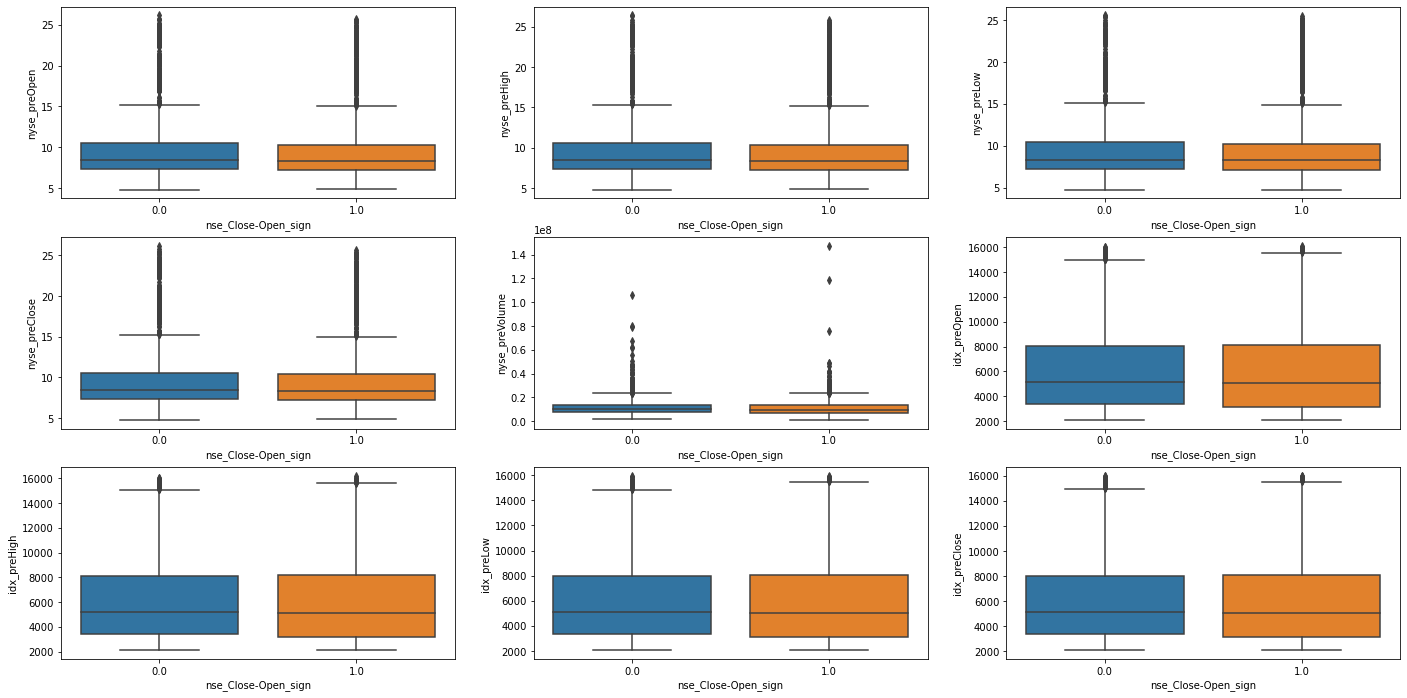

In [6]:
cols = DF.iloc[:,1:-2].columns 
fig, axes = plt.subplots(3, 3, figsize=(24, 12))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.boxplot(x='nse_Close-Open_sign', y=col, data=DF, ax=ax)

plt.show()

## Scatter plot

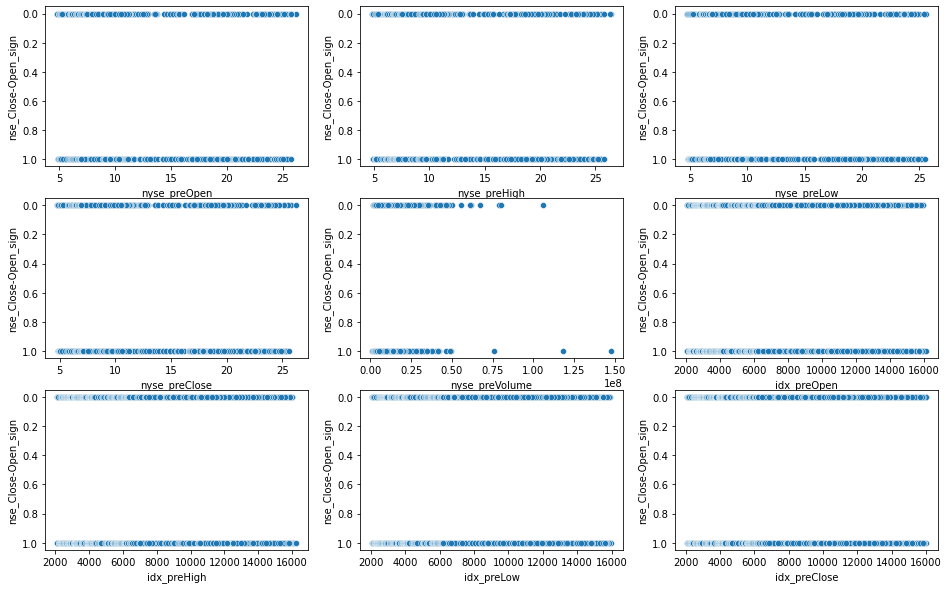

In [7]:
cols = DF.iloc[:,1:-2].columns 
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.scatterplot(x=col, y='nse_Close-Open_sign', data=DF, ax=ax)

plt.show()

## Histogram

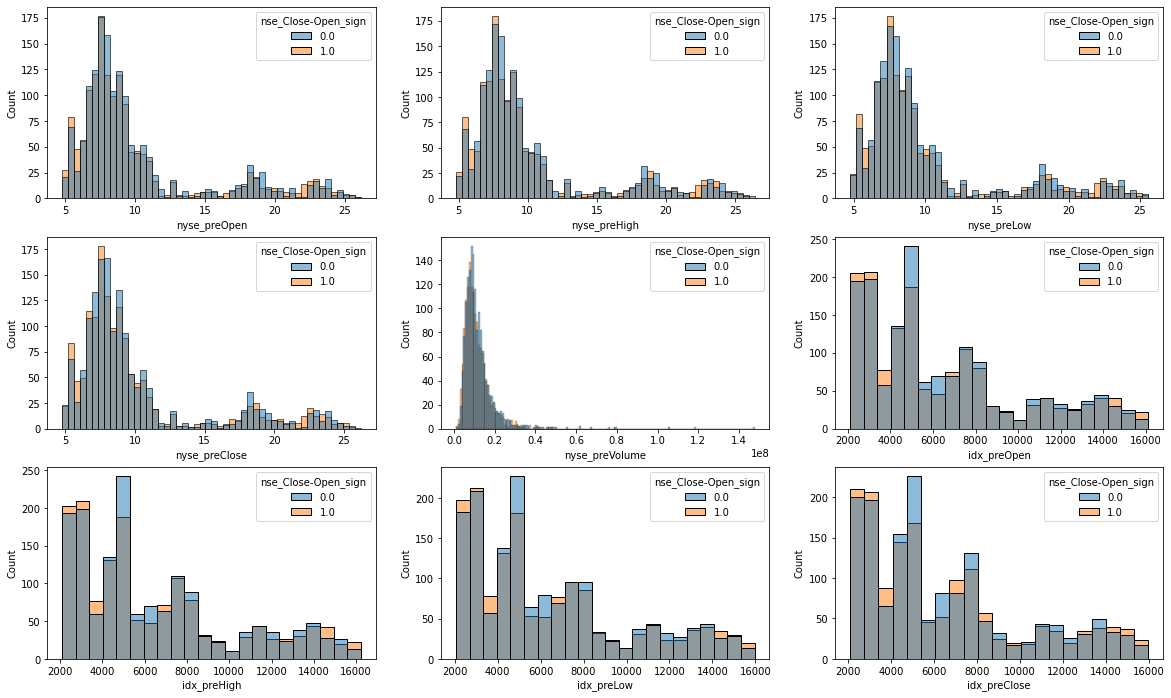

In [8]:
cols = DF.iloc[:,1:-2].columns 
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.histplot(x=col, hue='nse_Close-Open_sign', data=DF, ax=ax)

plt.show()

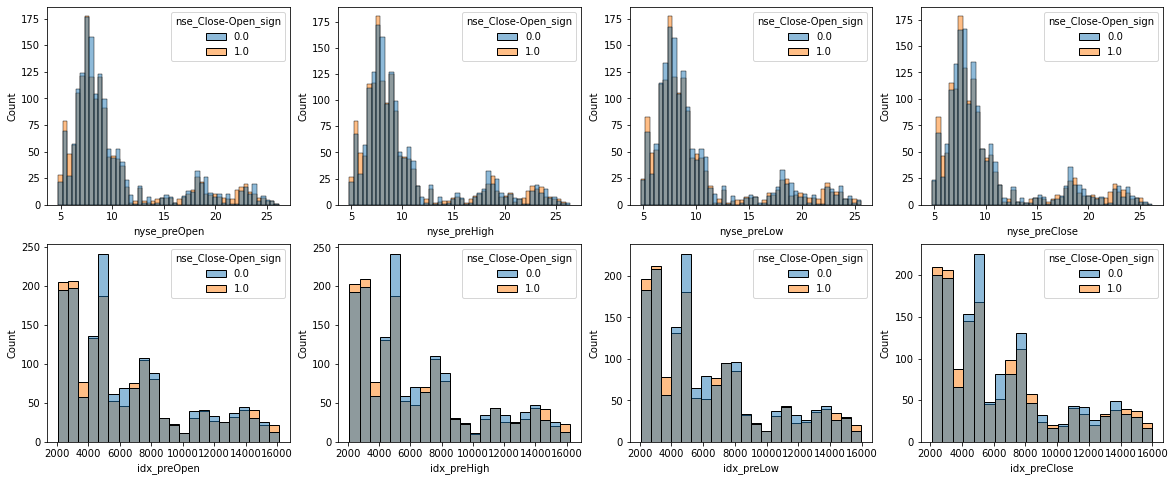

In [9]:
cols = DF.drop(columns="nyse_preVolume").iloc[:,1:-2].columns 
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.histplot(x=col, hue='nse_Close-Open_sign', data=DF, ax=ax)

plt.show()

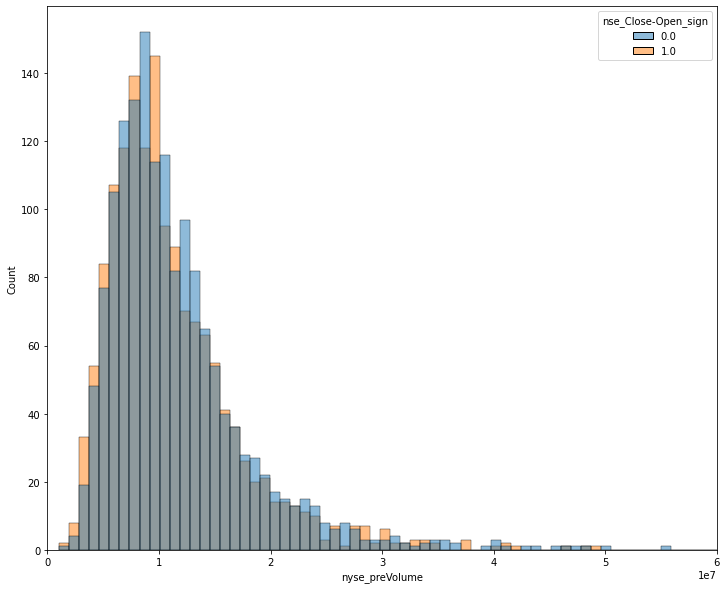

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.histplot(x='nyse_preVolume', hue='nse_Close-Open_sign', data=DF, ax=ax)
plt.xlim(0,60000000)
plt.show()

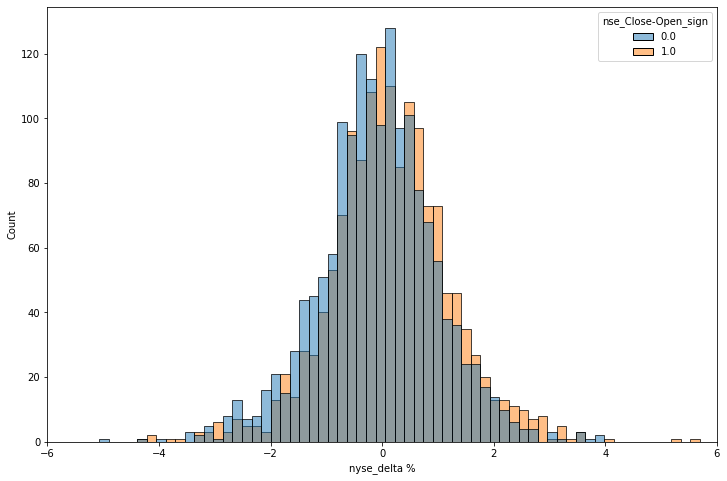

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(x='nyse_delta %', hue='nse_Close-Open_sign', data=DF, ax=ax)
plt.xlim(-6,6)
plt.show()

## Pair plot

The distribution of Close - Open > 0 and the distribution of Close - Open < 0 are almost same. There seems to be two (three) bumps in their distribution, which means price has shiftted over last 10 years.

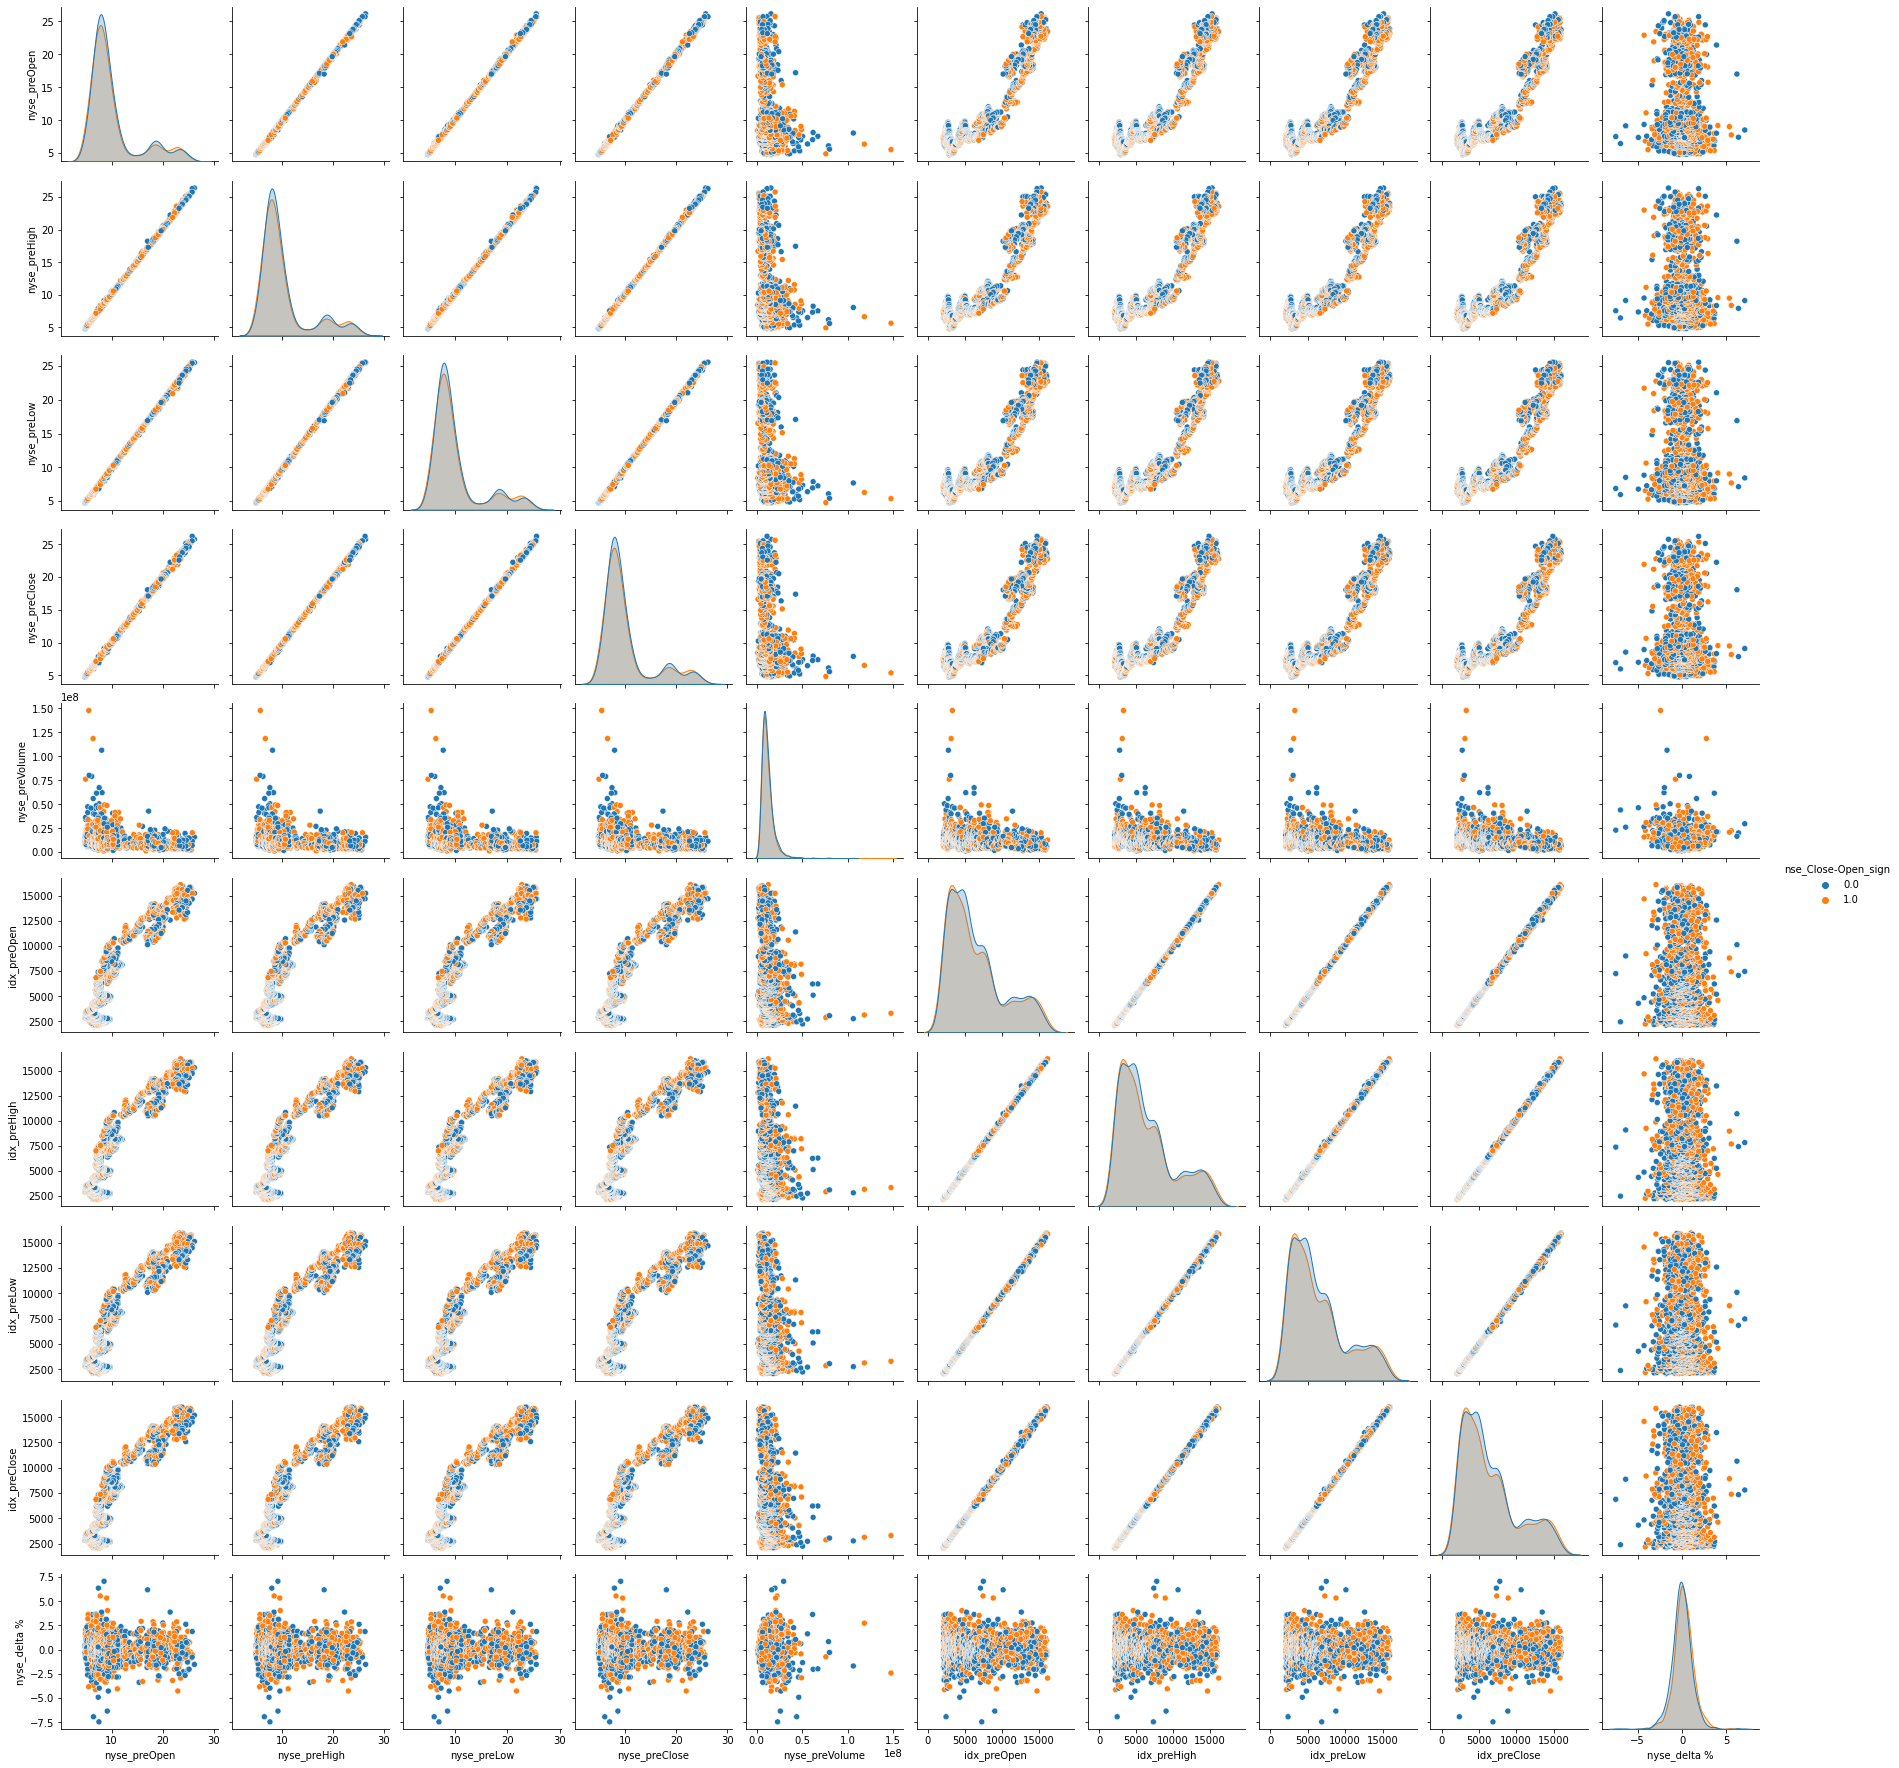

In [12]:
sns.pairplot(DF.iloc[:,:-2], hue = "nse_Close-Open_sign")

# Check the Percentage of nyse trends on the previous day that match nse trends on the next day

In [13]:
Direction = DF["nse_delta %"] * DF["nyse_delta %"]
sum(Direction > 0) * 100 / len(DF) 

52.52918287937743

# Each year

In [14]:
DF2 = test.DF_concat()
DF_10 = DF2[DF2["Date"].str.startswith('2010-')==True].drop(columns='Date')
DF_11 = DF2[DF2["Date"].str.startswith('2011-')==True].drop(columns='Date')
DF_12 = DF2[DF2["Date"].str.startswith('2012-')==True].drop(columns='Date')
DF_13 = DF2[DF2["Date"].str.startswith('2013-')==True].drop(columns='Date')
DF_14 = DF2[DF2["Date"].str.startswith('2014-')==True].drop(columns='Date')
DF_15 = DF2[DF2["Date"].str.startswith('2015-')==True].drop(columns='Date')
DF_16 = DF2[DF2["Date"].str.startswith('2016-')==True].drop(columns='Date')
DF_17 = DF2[DF2["Date"].str.startswith('2017-')==True].drop(columns='Date')
DF_18 = DF2[DF2["Date"].str.startswith('2018-')==True].drop(columns='Date')
DF_19 = DF2[DF2["Date"].str.startswith('2019-')==True].drop(columns='Date')
DF_20 = DF2[DF2["Date"].str.startswith('2020-')==True].drop(columns='Date')
DF_21 = DF2[DF2["Date"].str.startswith('2021-')==True].drop(columns='Date')
DF_22 = DF2[DF2["Date"].str.startswith('2022-')==True].drop(columns='Date')

## Time series of nse_Open change colored by nse_Close_Open

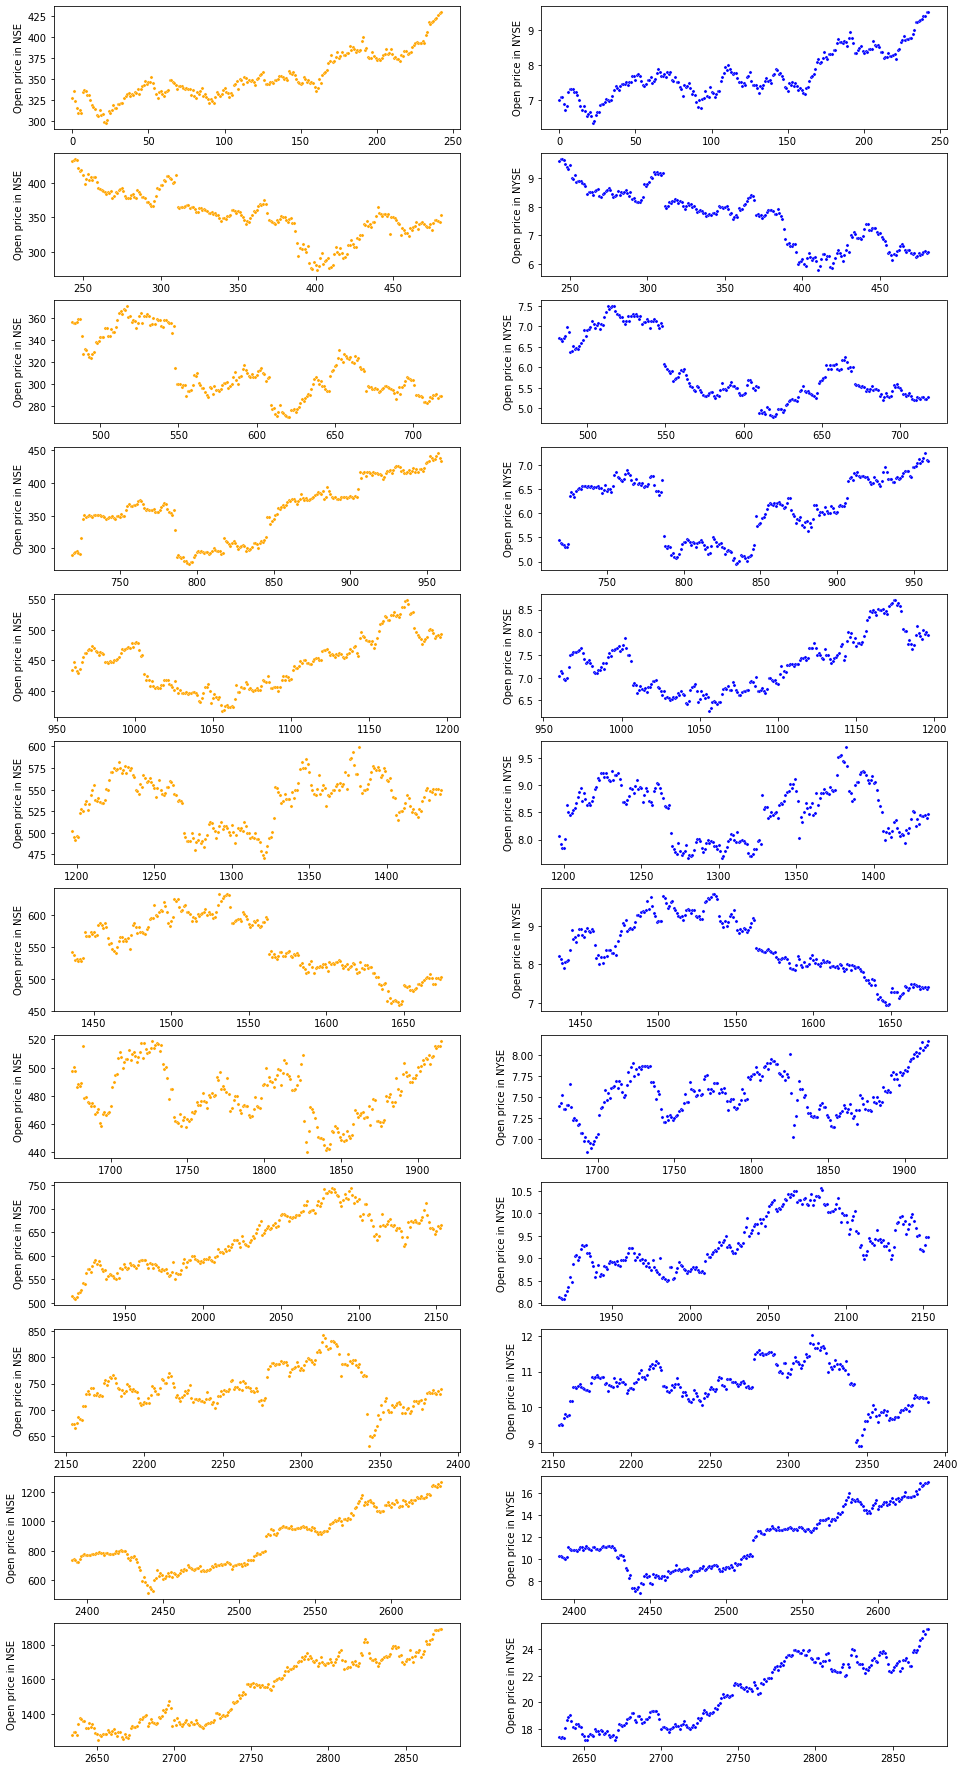

In [15]:
data = [DF_10,DF_11,DF_12,DF_13,DF_14,DF_15,DF_16,DF_17,DF_18,DF_19,DF_20,DF_21,DF_22]
fig, axes = plt.subplots(12, 2, figsize=(16, 32))
axes = axes.ravel()

axes0 = ([axes[0], axes[2], axes[4], axes[6], axes[8], axes[10], axes[12], axes[14], axes[16], axes[18], axes[20], axes[22]])
axes1 = ([axes[1], axes[3], axes[5], axes[7], axes[9], axes[11], axes[13], axes[15], axes[17], axes[19], axes[21], axes[23]])

for df, ax in zip(data, axes0):
    nse_plot = sns.scatterplot(x=df.index, y='nse_Open', data=df, ax=ax, s=10, color='orange')
    nse_plot.set_ylabel("Open price in NSE")

for df, ax in zip(data, axes1):
    nyse_plot = sns.scatterplot(x=df.index, y='nyse_preOpen', data=df, ax=ax, s=10, color='blue')
    nyse_plot.set_ylabel("Open price in NYSE")

plt.show()

# Demo - calculate returns assuming that the trend in nyse is reproduced in the next day's nse

In [16]:
df_demo_all = DF

df_demo_all['Day P&L %'] = 0
for i in df_demo_all.index:
    if df_demo_all["nyse_delta %"].iloc[i] != 0:
        df_demo_all['Day P&L %'].iloc[i] = \
        df_demo_all['nse_delta %'].iloc[i] * (df_demo_all['nyse_delta %'].iloc[i] / abs(df_demo_all['nyse_delta %'].iloc[i]))
df_demo_all['Daily short P&L %']=-1*(df_demo_all['nse_delta %'])
df_demo_all['Daily long P&L %']=(df_demo_all['nse_delta %'])

/Users/osawakentaro/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
# Cumulative return for trend following strategy
def cumulative_return(df, capital):
    comp=[]
    open_price=np.array(df['nse_Open'])
    day_pl=np.array(df['Day P&L %'])
    for i in range(0,len(df)):
        purchase_stock = (capital//open_price[i])*open_price[i]
        capital=(purchase_stock*(1+(day_pl[i]/100)))+(capital-purchase_stock)-0.0005*capital
        comp.append(capital)
    return comp


# Cumulative return for blind buying strategy
def cumulative_return_buy(df, capital):
    comp_buy=[]
    open_price=np.array(df['nse_Open'])
    buy_pl=np.array(df['Daily long P&L %'])
    for i in range(0,len(df)):
        purchase_stock = (capital//open_price[i])*open_price[i]
        capital=(purchase_stock*(1+(buy_pl[i]/100)))+(capital-purchase_stock)-0.0005*capital
        comp_buy.append(capital)
    return comp_buy

# Cumulative return for blind selling strategy
def cumulative_return_sell(df, capital):
    comp_sell=[]
    open_price=np.array(df['nse_Open'])
    sell_pl=np.array(df['Daily short P&L %'])
    for i in range(0,len(df)):
        purchase_stock = (capital//open_price[i])*open_price[i]
        capital=(purchase_stock*(1+(sell_pl[i]/100)))+(capital-purchase_stock)-0.0005*capital
        comp_sell.append(capital)
    return comp_sell

In [18]:
# Calculating the cumulative return for a capital of 800000 Rupee
comp=cumulative_return(df_demo_all, 800000)
comp_sell=cumulative_return_sell(df_demo_all, 800000)
comp_buy=cumulative_return_buy(df_demo_all, 800000)

In [19]:
# A dataframe consisting a cumulative return of sell first:buy later and buy first:sell later strategy 
line_dat=pd.DataFrame({'Daily sell@open & buy@close':comp_sell,'Daily buy@open & sell@close':comp_buy})

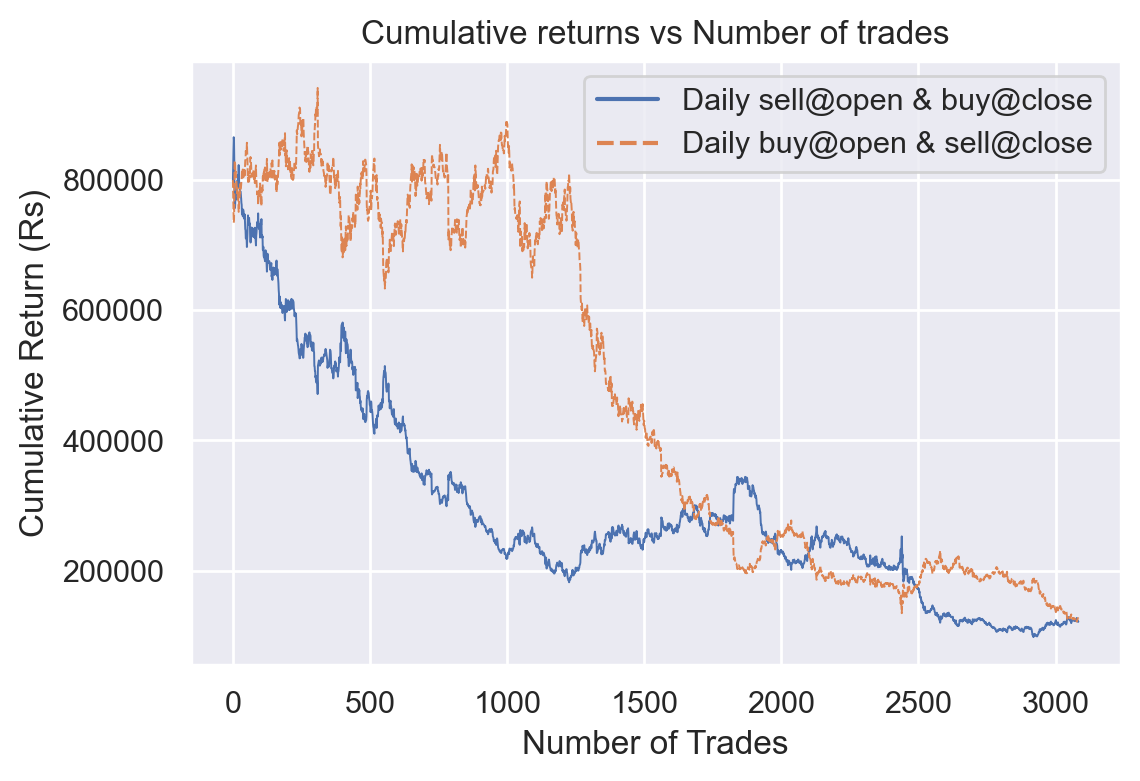

In [20]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':300})
axc=sns.lineplot(data=line_dat,lw=0.7);
axc.set(xlabel='Number of Trades',
       ylabel='Cumulative Return (Rs)',
       title='Cumulative returns vs Number of trades');

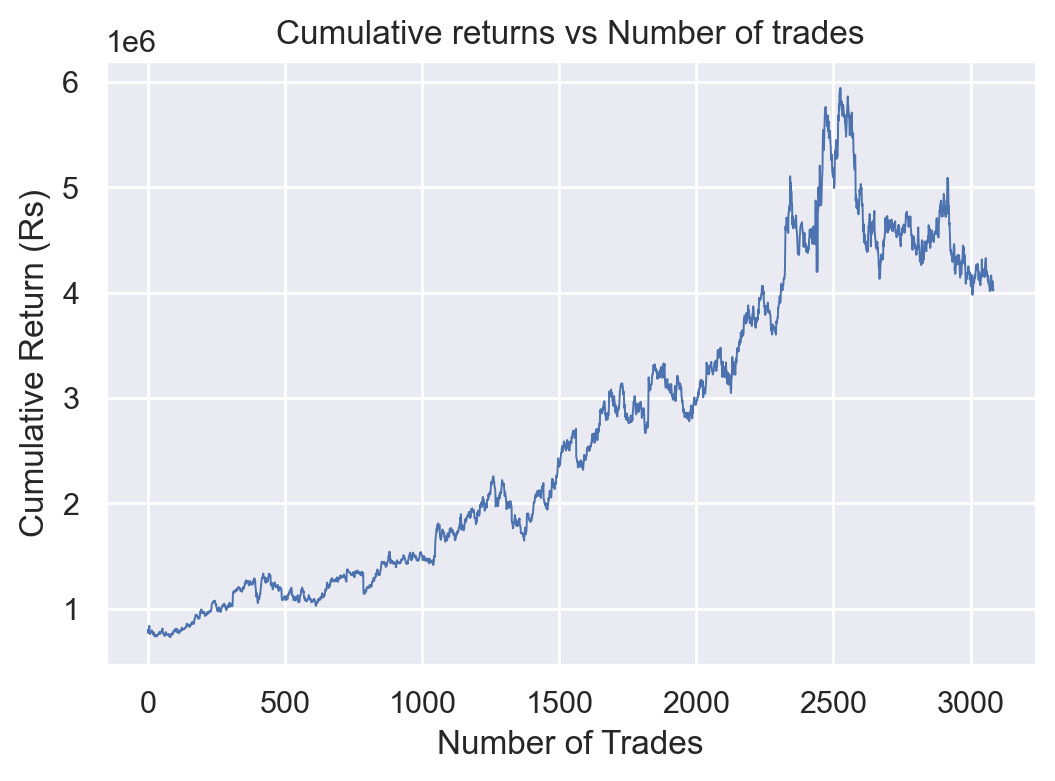

In [21]:
# Cumulative return of trend following strategy 
#sns.set(rc={"figure.dpi":200, 'savefig.dpi':300})
axc=sns.lineplot(data=comp,lw=0.7);
axc.set(xlabel='Number of Trades',
       ylabel='Cumulative Return (Rs)',
       title='Cumulative returns vs Number of trades');

# Model - logistic regression

In [22]:
x = DF.iloc[:,1:10]
y = DF.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

model=LogisticRegression(penalty='none', max_iter=1000)
model_fit = model.fit(x_train, y_train)
model_fit_score = model.score(x_train, y_train)

In [23]:
# fitted y and cofusion matrix
y_fit = model.predict(x_train)
cm_train = confusion_matrix(y_train, y_fit)
print(cm_train)
print(classification_report(y_train, y_fit))

[[670 429]
 [572 487]]
              precision    recall  f1-score   support

         0.0       0.54      0.61      0.57      1099
         1.0       0.53      0.46      0.49      1059

    accuracy                           0.54      2158
   macro avg       0.54      0.53      0.53      2158
weighted avg       0.54      0.54      0.53      2158



In [24]:
# predicted y and confusion matrix
y_predict = model.predict(x_test)
cm_test = confusion_matrix(y_test, y_predict)
print(cm_test)
print(classification_report(y_test, y_predict))

[[297 177]
 [250 202]]
              precision    recall  f1-score   support

         0.0       0.54      0.63      0.58       474
         1.0       0.53      0.45      0.49       452

    accuracy                           0.54       926
   macro avg       0.54      0.54      0.53       926
weighted avg       0.54      0.54      0.54       926



In [25]:
model.coef_

array([[-6.98981214, -2.42919587,  0.86074968,  8.50755189, -0.02079577,
         8.56267991, -5.69555529, -1.98276139, -0.83338066]])

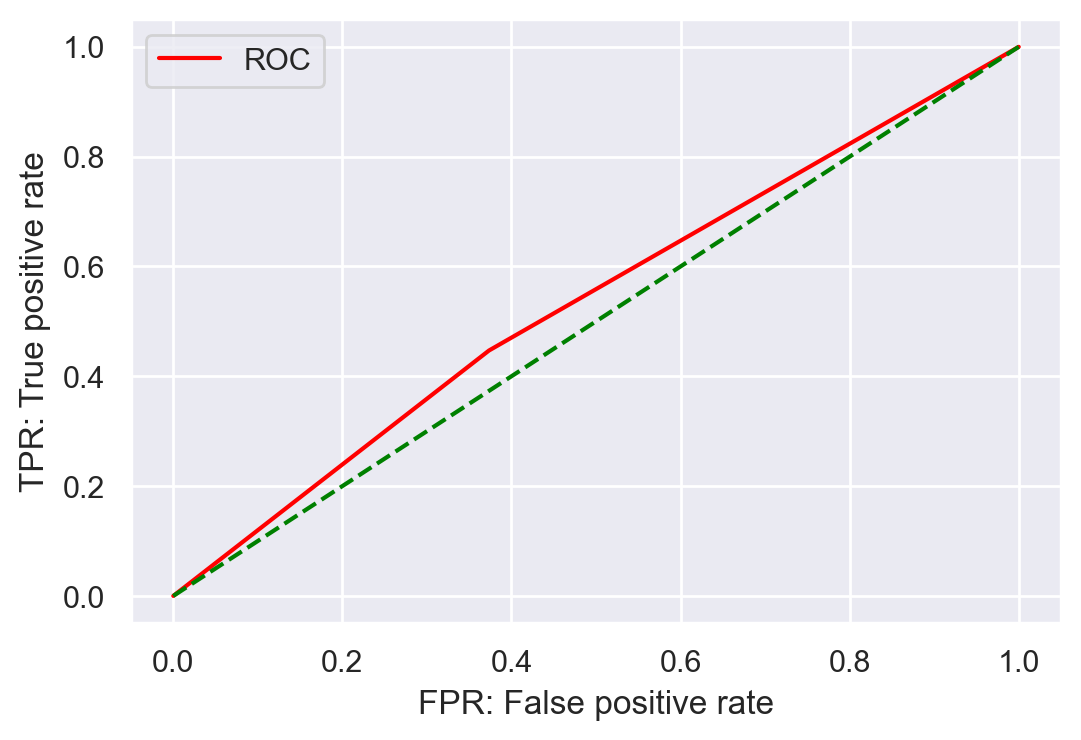

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_predict)

plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_predict))

0.5367424666741346


# Random forest

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

x = DF.iloc[:,1:10]
y = DF.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)


# model
rf = RandomForestClassifier(random_state=1000)

# learn from training data
rf.fit(x_train, y_train)

# predict
test = rf.predict(x_test)

# check accuracy
score = accuracy_score(y_test, test)
print(f"accuracy：{score * 100}%")

accuracy：50.43196544276458%


In [29]:
fti = rf.feature_importances_ 
for i, feat in enumerate(x.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

	nyse_preOpen         : 0.116806
	nyse_preHigh         : 0.103689
	nyse_preLow          : 0.103634
	nyse_preClose        : 0.105337
	nyse_preVolume       : 0.154125
	idx_preOpen          : 0.101733
	idx_preHigh          : 0.103882
	idx_preLow           : 0.102930
	idx_preClose         : 0.107865


In [36]:
from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = [None, 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
bootstrap = [True, False]
grid = {'n_estimators': n_estimators, 
        'max_features': max_features, 
        'max_depth': max_depth,
        'bootstrap': bootstrap}
rf_grid = GridSearchCV(estimator=rf, param_grid = grid, cv = 5)
rf_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1000),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 3, 4, 5],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]})

In [37]:
rf_grid.best_params_

{'bootstrap': True, 'max_depth': 3, 'max_features': None, 'n_estimators': 200}

In [30]:
rf2 = RandomForestClassifier(n_estimators=200, max_features=None, max_depth=3, bootstrap=True, random_state=1000)
rf2.fit(x_train, y_train)
test = rf2.predict(x_test)
score = accuracy_score(y_test, test)
print(f"accuracy：{score * 100}%")

accuracy：52.37580993520518%


In [31]:
# confusion matrix
cm_test = confusion_matrix(y_test, test)
print(cm_test)
print(classification_report(y_test, test))

[[364 110]
 [331 121]]
              precision    recall  f1-score   support

         0.0       0.52      0.77      0.62       474
         1.0       0.52      0.27      0.35       452

    accuracy                           0.52       926
   macro avg       0.52      0.52      0.49       926
weighted avg       0.52      0.52      0.49       926



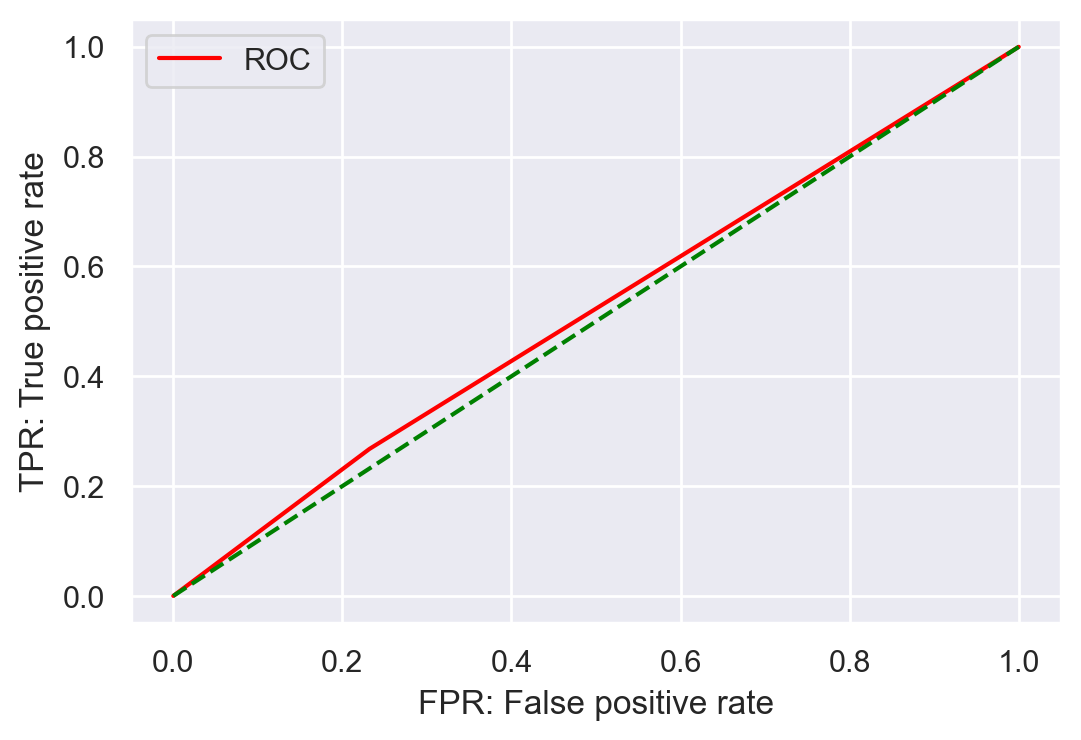

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, test)

plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.legend()
plt.show()

In [33]:
print(roc_auc_score(y_test, test))

0.5178158022478623


In [34]:
fti = rf2.feature_importances_ 
for i, feat in enumerate(x.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

	nyse_preOpen         : 0.151604
	nyse_preHigh         : 0.095225
	nyse_preLow          : 0.056832
	nyse_preClose        : 0.093616
	nyse_preVolume       : 0.220314
	idx_preOpen          : 0.073584
	idx_preHigh          : 0.095287
	idx_preLow           : 0.090984
	idx_preClose         : 0.122555


# Boosting

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

x = DF.iloc[:,1:10]
y = DF.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1000)
gb = GradientBoostingClassifier(random_state=1000)
gb.fit(x_train, y_train)

print("training accuracy: {:.3f}".format(gb.score(x_train, y_train)))
print("testing accuracy: {:.3f}".format(gb.score(x_test, y_test)))

training accuracy: 0.726
testing accuracy: 0.489


In [36]:
fti = gb.feature_importances_ 
for i, feat in enumerate(x.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

	nyse_preOpen         : 0.173663
	nyse_preHigh         : 0.085987
	nyse_preLow          : 0.088865
	nyse_preClose        : 0.120404
	nyse_preVolume       : 0.204974
	idx_preOpen          : 0.058141
	idx_preHigh          : 0.083723
	idx_preLow           : 0.081541
	idx_preClose         : 0.102703


In [43]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = [None, 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
learning_rate = [0.1, 0.01, 0.001, 0.0001]
grid = {'n_estimators': n_estimators, 
        'max_features': max_features, 
        'max_depth': max_depth,
        'learning_rate': learning_rate}
gb_grid = GridSearchCV(estimator=gb, param_grid = grid, cv = 5)
gb_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1000),
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]})

In [44]:
gb_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [66]:
gb2 = GradientBoostingClassifier(max_depth=2, n_estimators=100, max_features='sqrt', learning_rate=0.1, random_state=1000)
gb2.fit(x_train, y_train)
test = gb2.predict(x_test)
print("training accuracy: {:.3f}".format(gb2.score(x_train, y_train)))
print("testing accuracy: {:.3f}".format(gb2.score(x_test, y_test)))

training accuracy: 0.625
testing accuracy: 0.493


In [67]:
# confusion matrix
cm_test = confusion_matrix(y_test, test)
print(cm_test)
print(classification_report(y_test, test))

[[254 142]
 [249 126]]
              precision    recall  f1-score   support

         0.0       0.50      0.64      0.57       396
         1.0       0.47      0.34      0.39       375

    accuracy                           0.49       771
   macro avg       0.49      0.49      0.48       771
weighted avg       0.49      0.49      0.48       771



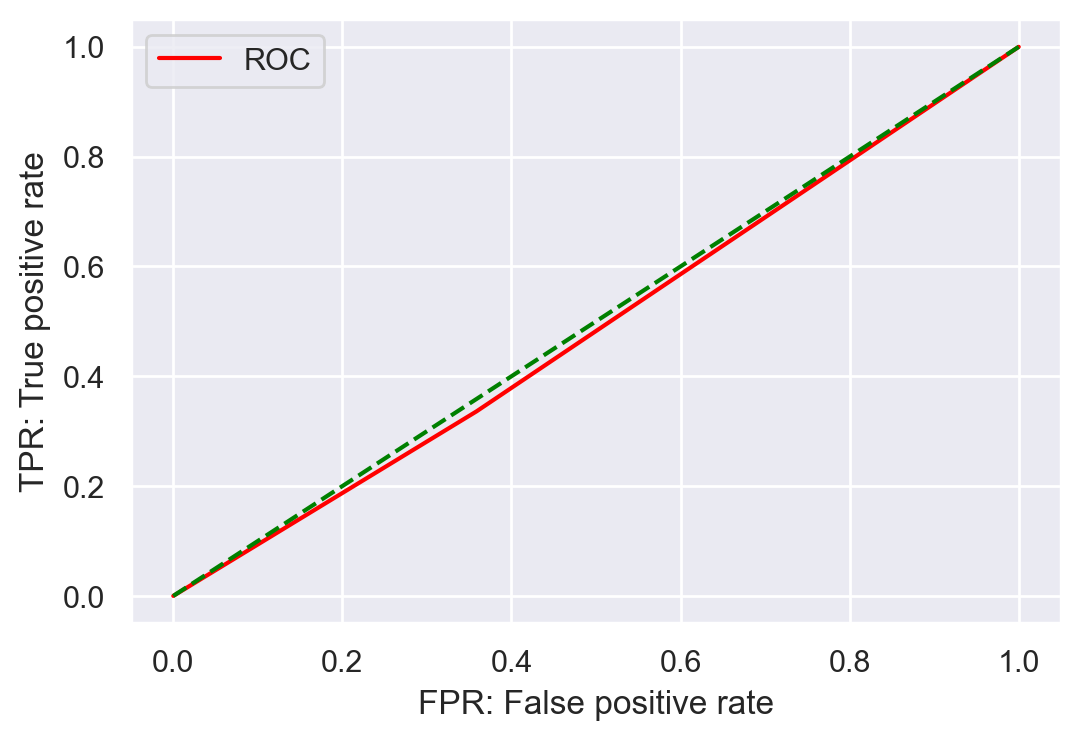

In [68]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, test)

plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.legend()
plt.show()

In [69]:
print(roc_auc_score(y_test, test))

0.48870707070707076


In [70]:
fti = gb2.feature_importances_ 
for i, feat in enumerate(x.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

	nyse_preOpen         : 0.139658
	nyse_preHigh         : 0.090101
	nyse_preLow          : 0.081550
	nyse_preClose        : 0.131612
	nyse_preVolume       : 0.214686
	idx_preOpen          : 0.061854
	idx_preHigh          : 0.090572
	idx_preLow           : 0.108757
	idx_preClose         : 0.081210


# Logistic regression - features reduced

In [41]:
x = DF.loc[:,['nyse_preOpen', 'nyse_preClose', 'nyse_preVolume']]
y = DF.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

model_rf=LogisticRegression(penalty='none', max_iter=1000)
model_rf_fit = model_rf.fit(x_train, y_train)
model_rf_fit_score = model_rf.score(x_train, y_train)

In [42]:
# fitted y and cofusion matrix
y_fit = model_rf.predict(x_train)
cm_train = confusion_matrix(y_train, y_fit)
print(cm_train)
print(classification_report(y_train, y_fit))

[[726 373]
 [628 431]]
              precision    recall  f1-score   support

         0.0       0.54      0.66      0.59      1099
         1.0       0.54      0.41      0.46      1059

    accuracy                           0.54      2158
   macro avg       0.54      0.53      0.53      2158
weighted avg       0.54      0.54      0.53      2158



In [43]:
# predicted y and confusion matrix
y_predict = model_rf.predict(x_test)
cm_test = confusion_matrix(y_test, y_predict)
print(cm_test)
print(classification_report(y_test, y_predict))

[[321 153]
 [271 181]]
              precision    recall  f1-score   support

         0.0       0.54      0.68      0.60       474
         1.0       0.54      0.40      0.46       452

    accuracy                           0.54       926
   macro avg       0.54      0.54      0.53       926
weighted avg       0.54      0.54      0.53       926



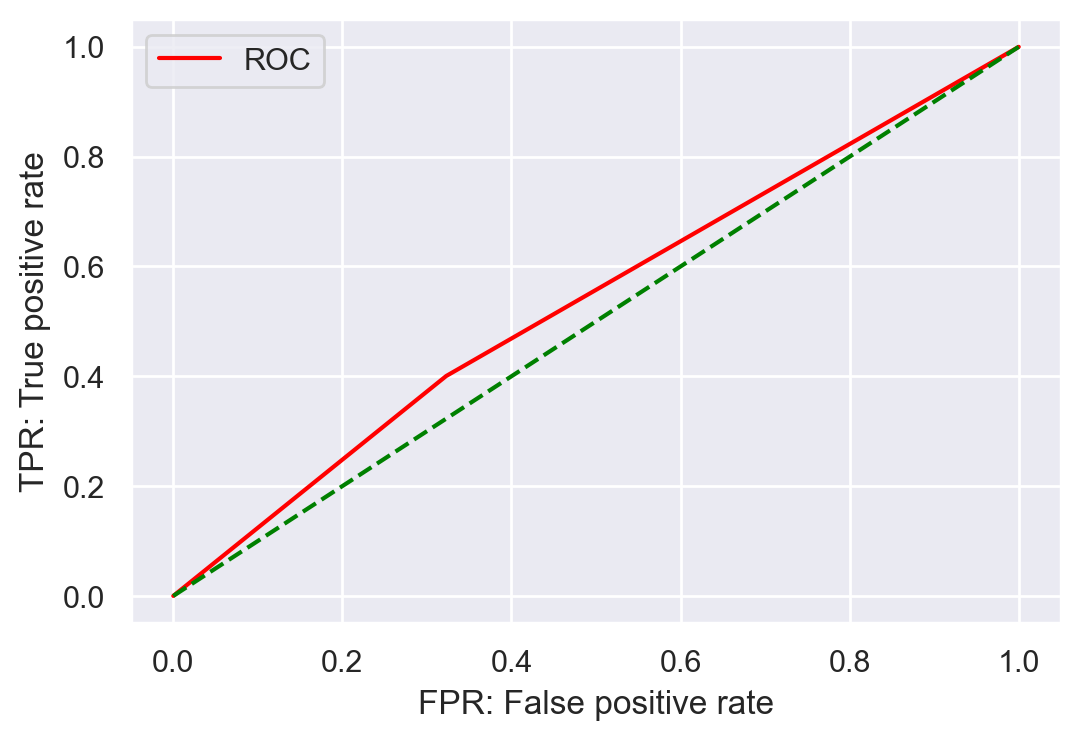

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_predict)

plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.legend()
plt.show()

In [45]:
print(roc_auc_score(y_test, y_predict))

0.538828833874762


In [51]:
model_rf.coef_

array([[-5.3793651 ,  5.36950525, -0.03751534]])

# Random Forest - features reduced

In [46]:
x = DF.loc[:,['nyse_preOpen', 'nyse_preClose', 'nyse_preVolume']]
y = DF.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)


# model
rf_fr = RandomForestClassifier(random_state=1000)

# learn from training data
rf_fr.fit(x_train, y_train)

# predict
test = rf_fr.predict(x_test)

# check accuracy
score = accuracy_score(y_test, test)
print(f"accuracy：{score * 100}%")

accuracy：51.18790496760259%


In [53]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = [None, 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
bootstrap = [True, False]
grid = {'n_estimators': n_estimators, 
        'max_features': max_features, 
        'max_depth': max_depth,
        'bootstrap': bootstrap}
rf_grid = GridSearchCV(estimator=rf_fr, param_grid = grid, cv = 5)
rf_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1000),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 3, 4, 5],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]})

In [54]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [47]:
rf2 = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=5, bootstrap=True, random_state=1000)
rf2.fit(x_train, y_train)
test = rf2.predict(x_test)
score = accuracy_score(y_test, test)
print(f"accuracy：{score * 100}%")

accuracy：50.9719222462203%


In [48]:
print(roc_auc_score(y_test, test))

0.5043594339270377


# Boosting - features reduced

In [49]:
x = DF.loc[:,['nyse_preOpen', 'nyse_preClose', 'nyse_preVolume']]
y = DF.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1000)
gb_fr = GradientBoostingClassifier(random_state=1000)
gb_fr.fit(x_train, y_train)

print("training accuracy: {:.3f}".format(gb_fr.score(x_train, y_train)))
print("testing accuracy: {:.3f}".format(gb_fr.score(x_test, y_test)))

training accuracy: 0.692
testing accuracy: 0.502


In [65]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = [None, 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
learning_rate = [0.1, 0.01, 0.001, 0.0001]
grid = {'n_estimators': n_estimators, 
        'max_features': max_features, 
        'max_depth': max_depth,
        'learning_rate': learning_rate}
gb_grid = GridSearchCV(estimator=gb_fr, param_grid = grid, cv = 5)
gb_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1000),
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]})

In [66]:
gb_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'max_features': 'sqrt',
 'n_estimators': 700}

In [53]:
gb2 = GradientBoostingClassifier(max_depth=2, n_estimators=700, max_features='sqrt', learning_rate=0.1, random_state = 1000)
gb2.fit(x_train, y_train)
test = gb2.predict(x_test)
print("training accuracy: {:.3f}".format(gb2.score(x_train, y_train)))
print("testing accuracy: {:.3f}".format(gb2.score(x_test, y_test)))

training accuracy: 0.765
testing accuracy: 0.514


In [54]:
print(roc_auc_score(y_test, test))

0.5125151515151515


# Demo

In [68]:
# Best model
x = DF.loc[:,['nyse_preOpen', 'nyse_preClose', 'nyse_preVolume']]
y = DF.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

model_rf=LogisticRegression(penalty='none', max_iter=1000)
model_rf_fit = model_rf.fit(x_train, y_train)
model_rf_fit_score = model_rf.score(x_train, y_train)

# concat y_test data and predicted y
y_test2 = pd.DataFrame(y_test) # convert y_test into dataframe
y_test2['predicted_sign'] = model_rf.predict(x_test)
y_test2

,nse_Close-Open_sign,predicted_sign
58,0.0,1.0
1400,1.0,0.0
1285,1.0,0.0
2960,0.0,1.0
1794,0.0,0.0
...,...,...
2968,1.0,0.0
110,1.0,1.0
2281,1.0,0.0
2926,1.0,0.0


In [69]:
df_demo_test = pd.merge(DF.drop(columns="nse_Close-Open_sign"),y_test2,
                        left_index=True, right_index=True).loc[:,["nse_Open", "nse_delta %", "nse_Close-Open_sign", "predicted_sign"]] 

In [70]:
# Tabulating the % change for three different strategies
df_demo_test['Day P&L %']=df_demo_test['nse_delta %']
for i in range(0,len(df_demo_test.index)):
    if df_demo_test['nse_Close-Open_sign'].iloc[i] == df_demo_test['predicted_sign'].iloc[i]:
        df_demo_test['Day P&L %'].iloc[i] = abs(df_demo_test['Day P&L %'].iloc[i])
    elif df_demo_test['nse_Close-Open_sign'].iloc[i] != df_demo_test['predicted_sign'].iloc[i]:
        df_demo_test['Day P&L %'].iloc[i] = -1*abs(df_demo_test['Day P&L %'].iloc[i])
        
df_demo_test['Daily short P&L %']=-1*(df_demo_test['nse_delta %'])
df_demo_test['Daily long P&L %']=(df_demo_test['nse_delta %'])

/Users/osawakentaro/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [71]:
df_demo_test

,nse_Open,nse_delta %,nse_Close-Open_sign,predicted_sign,Day P&L %,Daily short P&L %,Daily long P&L %
3,314.875000,-2.175468,0.0,0.0,2.175468,2.175468,-2.175468
4,309.387512,0.587847,1.0,1.0,0.587847,-0.587847,0.587847
7,334.875000,0.401269,1.0,0.0,-0.401269,-0.401269,0.401269
10,331.081238,0.341685,1.0,1.0,0.341685,-0.341685,0.341685
14,316.500000,-1.174961,0.0,0.0,1.174961,1.174961,-1.174961
...,...,...,...,...,...,...,...
3067,1518.500000,-0.042807,0.0,1.0,-0.042807,0.042807,-0.042807
3073,1572.000000,-1.189564,0.0,0.0,1.189564,1.189564,-1.189564
3076,1521.400024,-0.916923,0.0,0.0,0.916923,0.916923,-0.916923
3079,1546.650024,1.516177,1.0,1.0,1.516177,-1.516177,1.516177


In [74]:
# Calculating the cumulative return for a capital of 800000 INR
comp=cumulative_return(df_demo_test, 800000)
comp_sell=cumulative_return_sell(df_demo_test, 800000)
comp_buy=cumulative_return_buy(df_demo_test, 800000)

In [75]:
# A dataframe consisting a cumulative return of sell first:buy later and buy first:sell later strategy 
line_dat=pd.DataFrame({'Daily sell@open & buy@close':comp_sell,'Daily buy@open & sell@close':comp_buy})

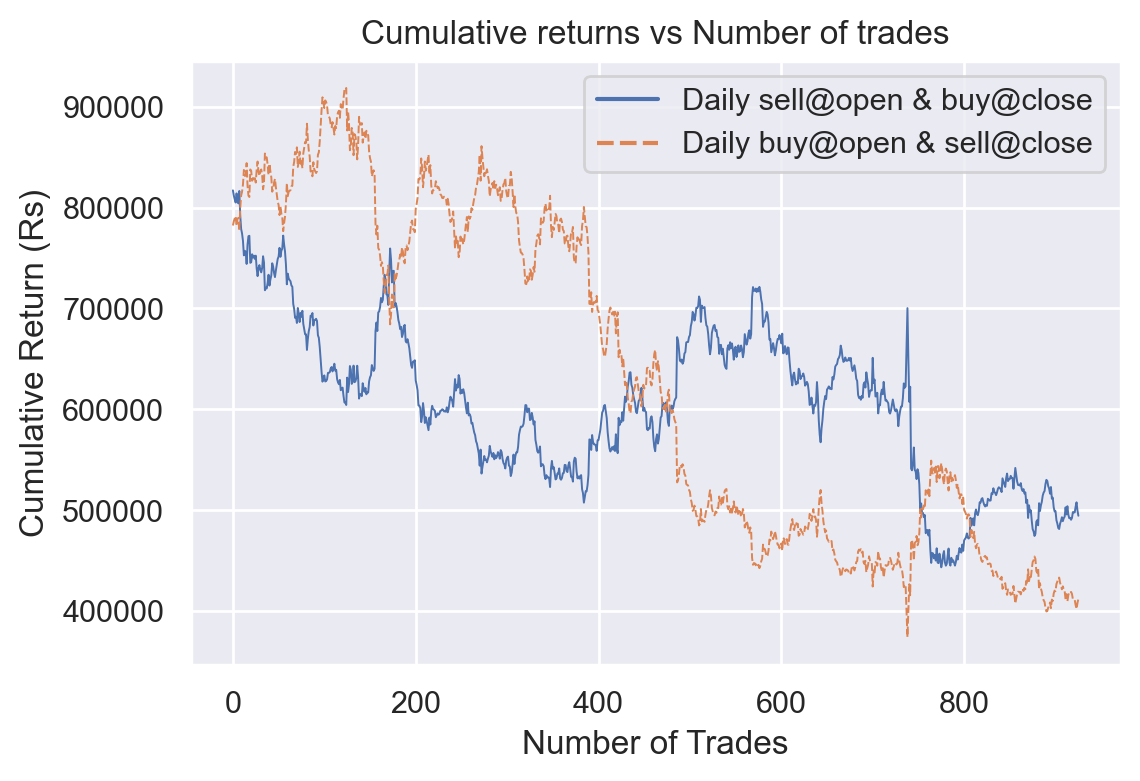

In [76]:
#sns.set(rc={"figure.dpi":200, 'savefig.dpi':300})
axc=sns.lineplot(data=line_dat,lw=0.7);
axc.set(xlabel='Number of Trades',
       ylabel='Cumulative Return (Rs)',
       title='Cumulative returns vs Number of trades');

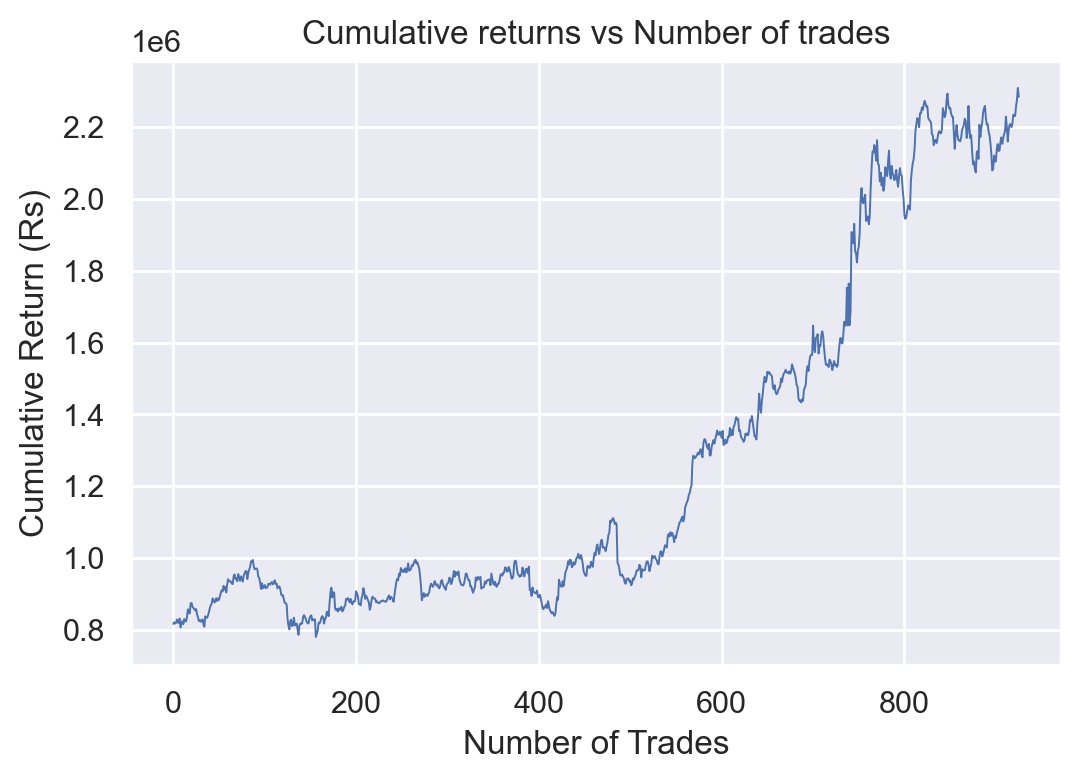

In [77]:
# Cumulative return of using model prediction
#sns.set(rc={"figure.dpi":200, 'savefig.dpi':300})
axc=sns.lineplot(data=comp,lw=0.7);
axc.set(xlabel='Number of Trades',
       ylabel='Cumulative Return (Rs)',
       title='Cumulative returns vs Number of trades');